# EEG Event‑Specific Visualizations

This notebook generates **comprehensive visualizations for each experimental event** in your BrainVision EEG recording.
It was auto‑generated by ChatGPT on 2025‑06‑d.

## Usage
1. Edit the file‑path variables under **File paths**.
2. Run the notebook top‑to‑bottom.
3. Figures are stored in a `figures/` folder for easy inclusion in reports.


In [1]:

# --------------------------- Imports & settings ---------------------------
import os
from pathlib import Path
import numpy as np
import mne
import matplotlib.pyplot as plt

%matplotlib inline
mne.set_log_level("WARNING")

# Output folders
FIG_DIR = Path("Visualisations")
FIG_DIR.mkdir(exist_ok=True)

DERIV_DIR = Path("derivatives")
DERIV_DIR.mkdir(exist_ok=True)

# Utility: find peak latency
def find_latency(evoked, time_window=(0.05, 0.4), mode='pos'):
    """Return latency (s) of max/min deflection within a window."""
    mask = (evoked.times >= time_window[0]) & (evoked.times <= time_window[1])
    data = evoked.data[:, mask]
    idx = (np.argmax if mode == 'pos' else np.argmin)(data)
    chan, t_idx = np.unravel_index(idx, data.shape)
    return evoked.times[mask][t_idx]


In [2]:

# --------------------------- File paths ---------------------------
SUBJECT = "Subject_05"
RUN     = "Fatigue_05"
root_dir = Path("./experiment_data")

vhdr_fname = root_dir / SUBJECT / "EEG" / f"{RUN}.vhdr"
assert vhdr_fname.exists(), f"File not found: {vhdr_fname}"

# --------------------------- Load & preprocess ---------------------------
raw = mne.io.read_raw_brainvision(vhdr_fname, preload=True)
raw.set_montage("standard_1020")

# Basic band‑pass filter
raw.filter(1., 40., fir_design='firwin')


<RawBrainVision | Fatigue_05.eeg, 14 x 848400 (848.4 s), ~90.6 MB, data loaded>

Original mapping: {np.str_('New Segment/'): 99999, np.str_('Response/R  1'): 1001, np.str_('Response/R  3'): 1003}
Renamed mapping: {'stimulus': 1001, 'answer': 1003}


/var/folders/3j/w0qrc74d6sj7fjdwc593xcqc0000gn/T/ipykernel_17474/3051850469.py:13: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(events, event_id=event_id, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)


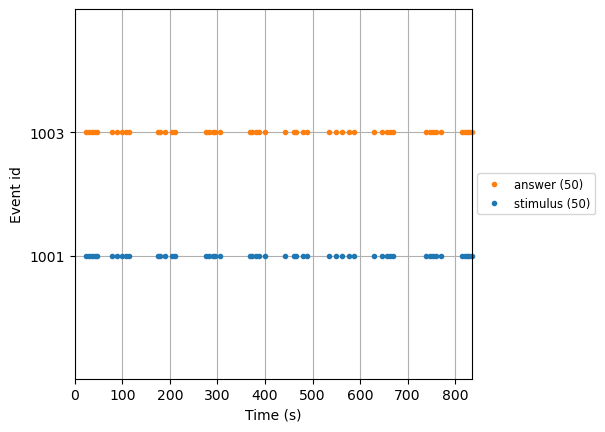

In [3]:

# --------------------------- Events ---------------------------
events, event_id_orig = mne.events_from_annotations(raw)
print("Original mapping:", event_id_orig)

rename_map = {
    "Response/R  1": "stimulus",
    "Response/R  3": "answer",
}
event_id = {new: event_id_orig[old] for old, new in rename_map.items() if old in event_id_orig}
assert len(event_id) == 2, "Expect exactly 2 events"
print("Renamed mapping:", event_id)

mne.viz.plot_events(events, event_id=event_id, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)
plt.savefig(FIG_DIR / "events_overview.png", dpi=150)


In [4]:

# --------------------------- Epochs ---------------------------
tmin, tmax = -0.2, 0.8
epochs = mne.Epochs(
    raw, events, event_id,
    tmin=tmin, tmax=tmax,
    baseline=(None, 0),
    event_repeated='merge',
    preload=True
)
print(epochs)


<Epochs | 100 events (all good), -0.2 – 0.8 s (baseline -0.2 – 0 s), ~10.7 MB, data loaded,
 'stimulus': 50
 'answer': 50>


### 1. ERP Joint Plots

<Figure size 640x480 with 0 Axes>

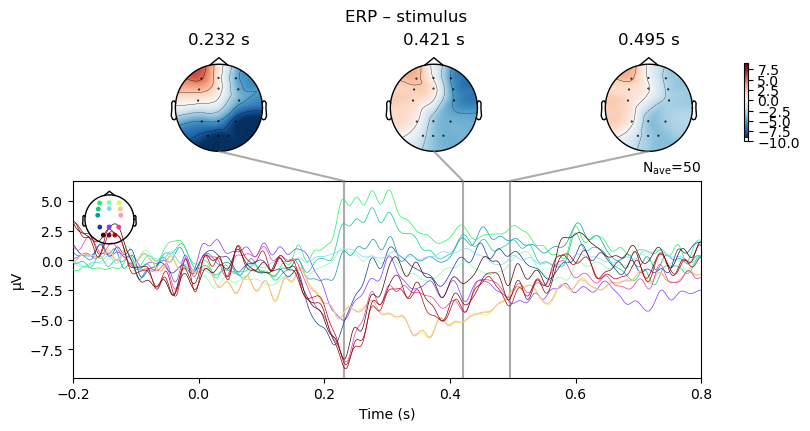

<Figure size 640x480 with 0 Axes>

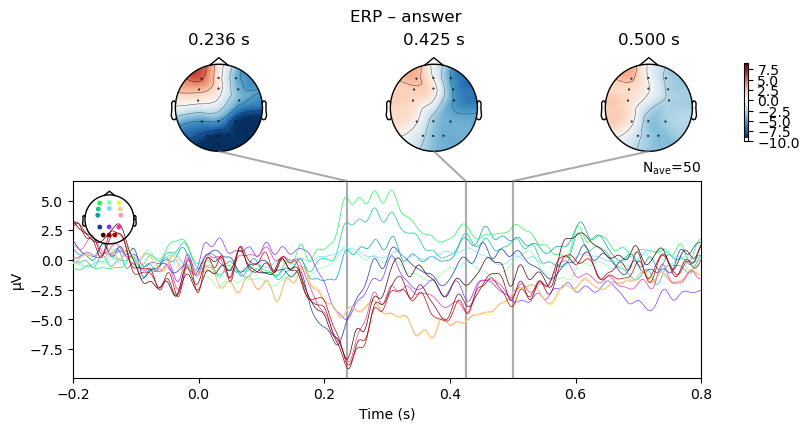

<Figure size 640x480 with 0 Axes>

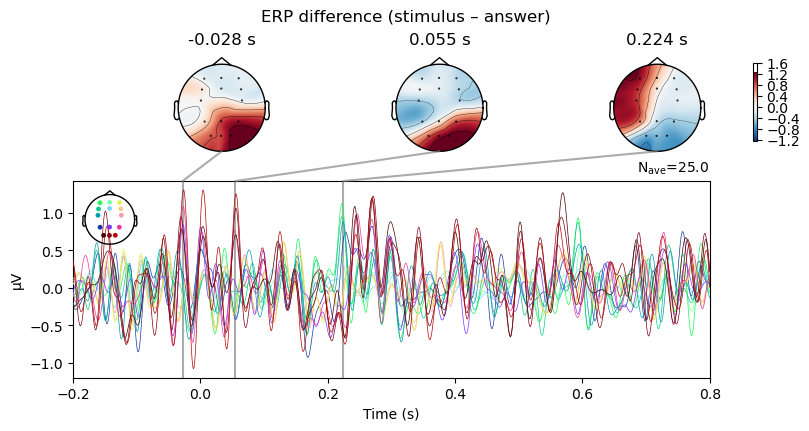

In [5]:

evoked_dict = {}
for cond in event_id:
    evoked = epochs[cond].average()
    evoked.apply_baseline((None, 0))
    evoked_dict[cond] = evoked

    evoked.plot_joint(title=f"ERP – {cond}", times='peaks')
    plt.savefig(FIG_DIR / f"erp_joint_{cond}.png", dpi=150)

diff_evoked = mne.combine_evoked([evoked_dict['stimulus'], evoked_dict['answer']], weights=[1, -1])
diff_evoked.plot_joint(title="ERP difference (stimulus – answer)", times='peaks')
plt.savefig(FIG_DIR / "erp_joint_difference.png", dpi=150)


### 2. Peak‑Latency Topographies

<Figure size 640x480 with 0 Axes>

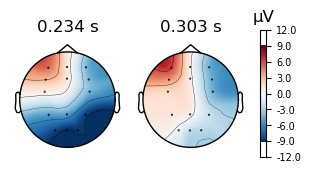

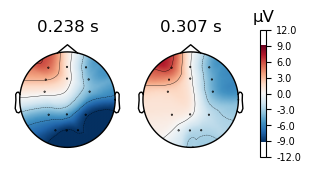

In [7]:

for cond, evoked in evoked_dict.items():
    lat_pos = find_latency(evoked, mode='pos')
    lat_neg = find_latency(evoked, mode='neg')

    fig = evoked.plot_topomap(times=[lat_neg, lat_pos], ch_type='eeg', time_unit='s')
    fig.savefig(FIG_DIR / f"topomap_peaks_{cond}.png", dpi=150)


### 3. Power Spectral Density

In [8]:

for cond in event_id:
    epochs[cond].plot_psd(fmin=1, fmax=40, average=True, spatial_colors=False)
    plt.suptitle(f"PSD – {cond}")
    plt.savefig(FIG_DIR / f"psd_{cond}.png", dpi=150)


/Users/rahul/miniconda3/envs/thesis-ml/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/Users/rahul/miniconda3/envs/thesis-ml/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


### 4. Time‑Frequency Representations (Morlet)

/var/folders/3j/w0qrc74d6sj7fjdwc593xcqc0000gn/T/ipykernel_17474/2132749444.py:9: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  power.plot(picks='eeg', title=f"TFR – {cond}", vmin=-0.5, vmax=0.5, cmap='RdBu_r')


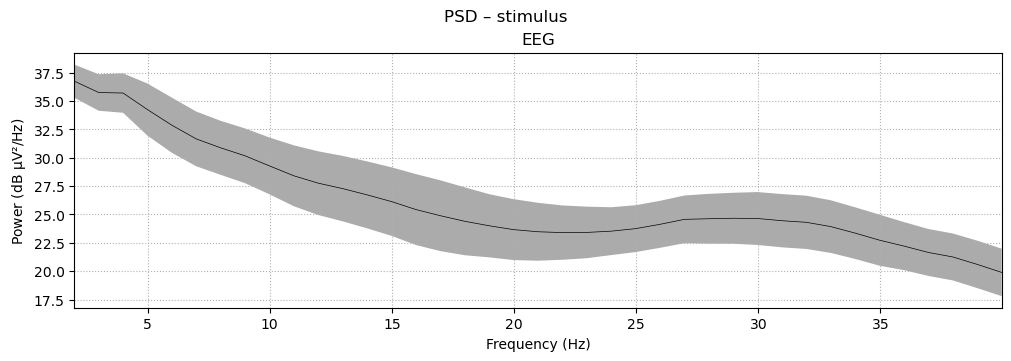

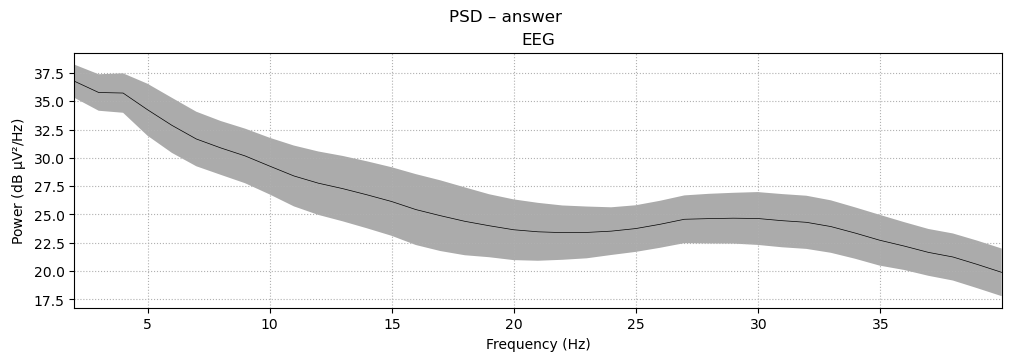

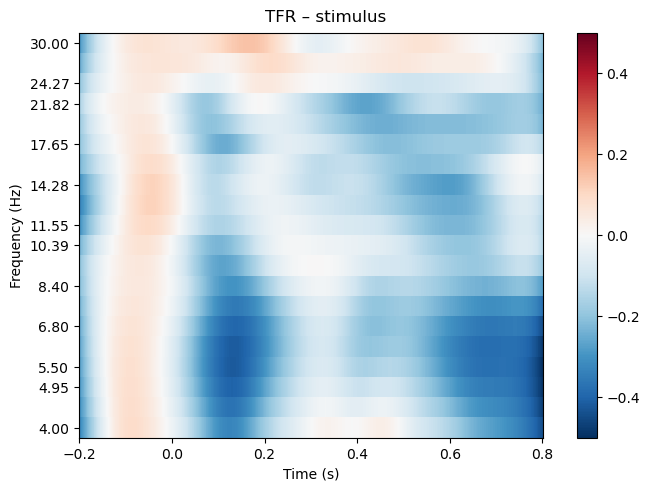

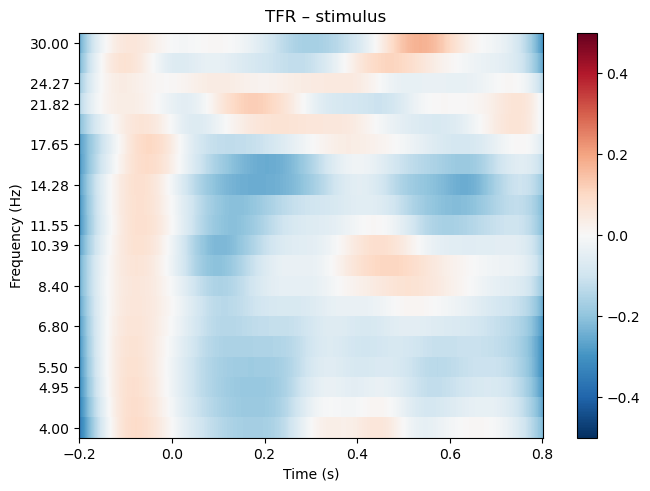

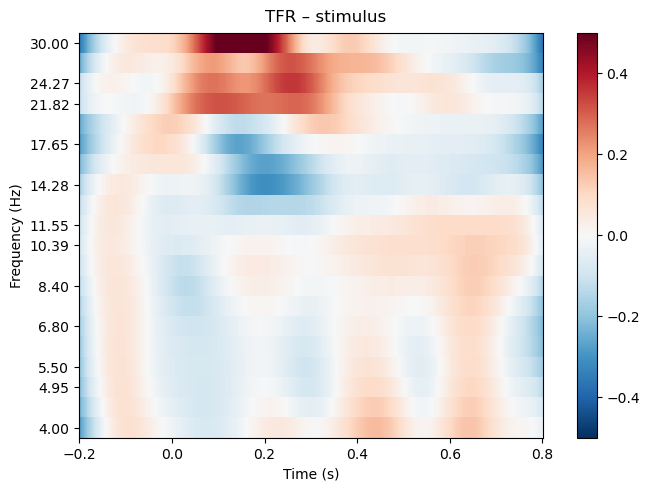

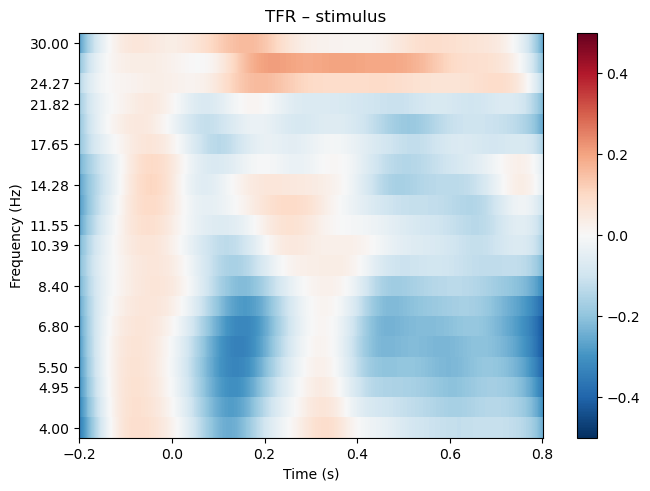

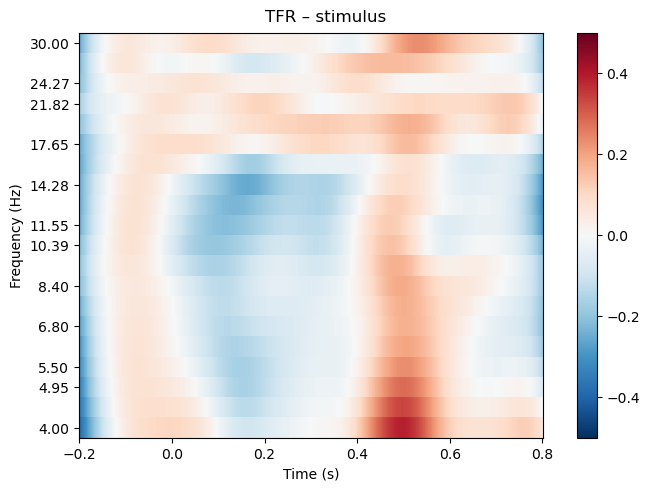

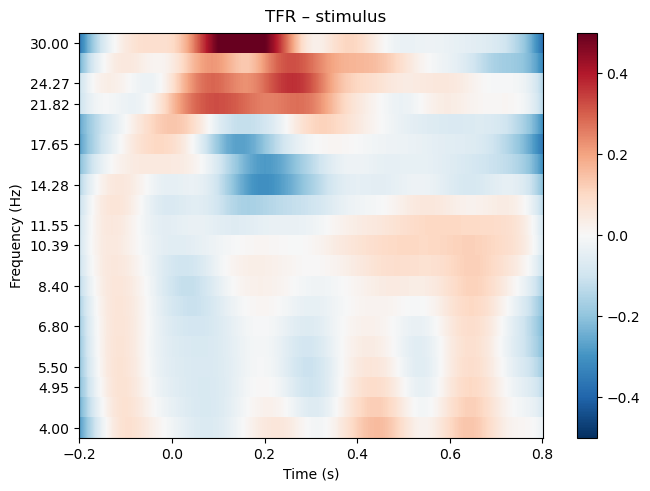

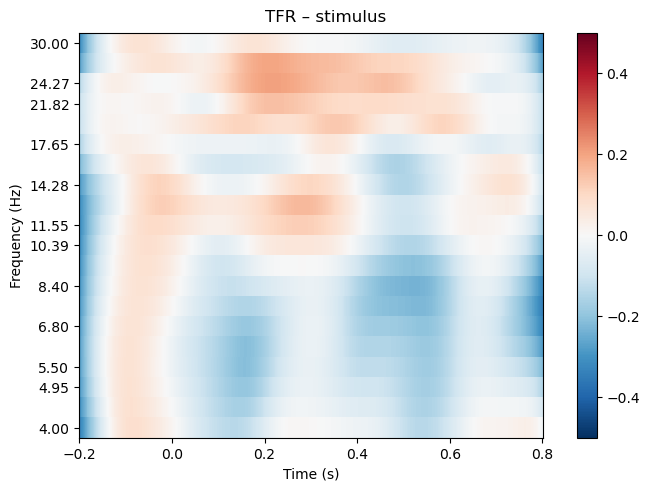

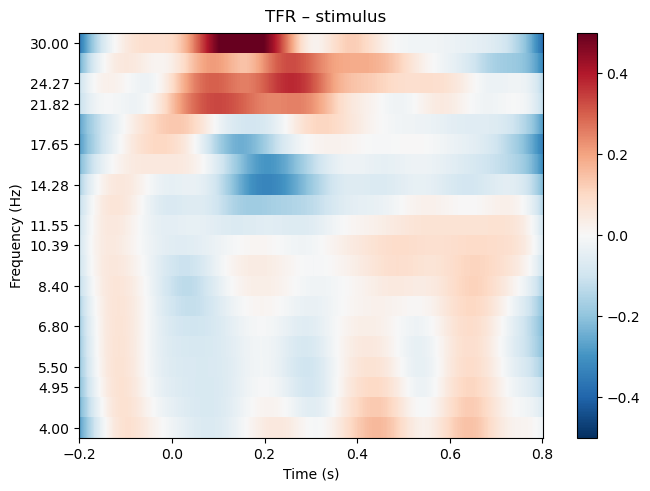

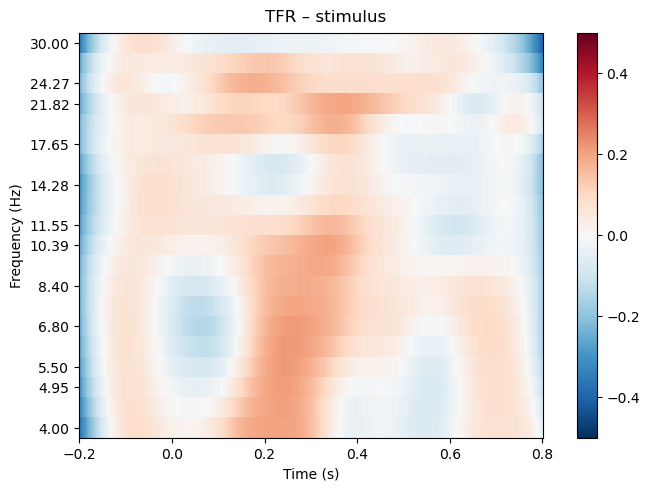

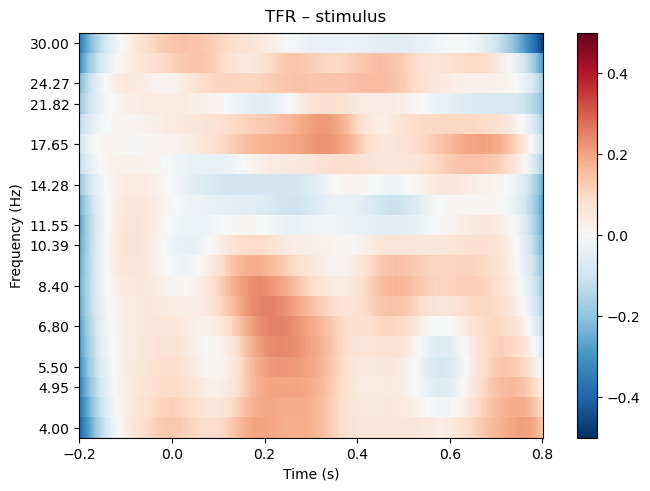

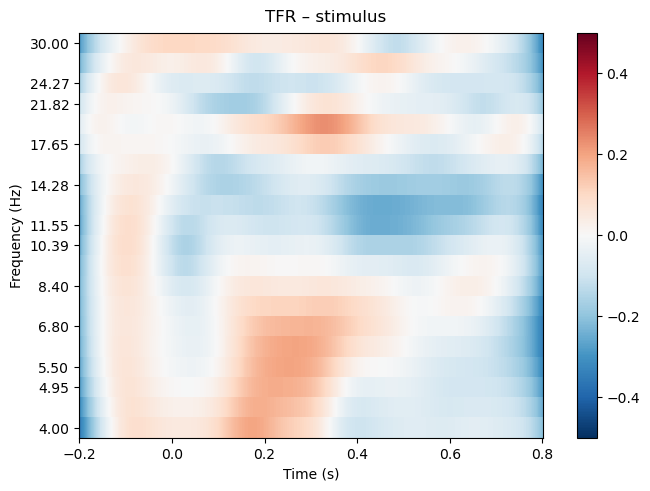

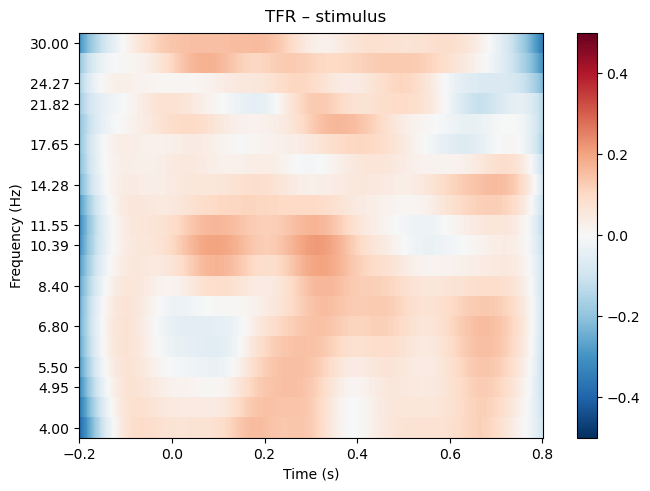

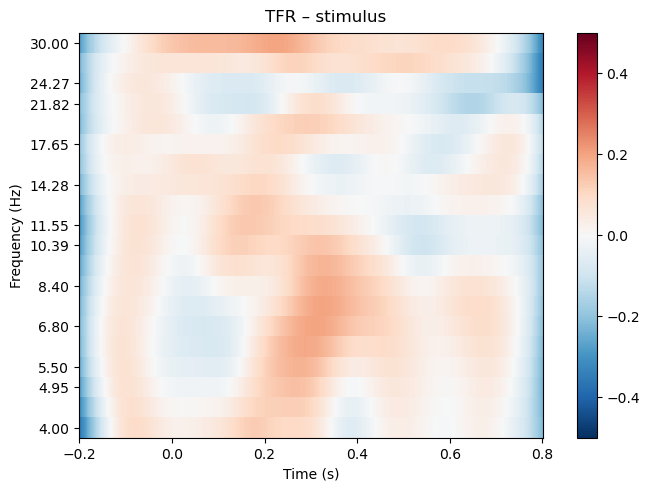

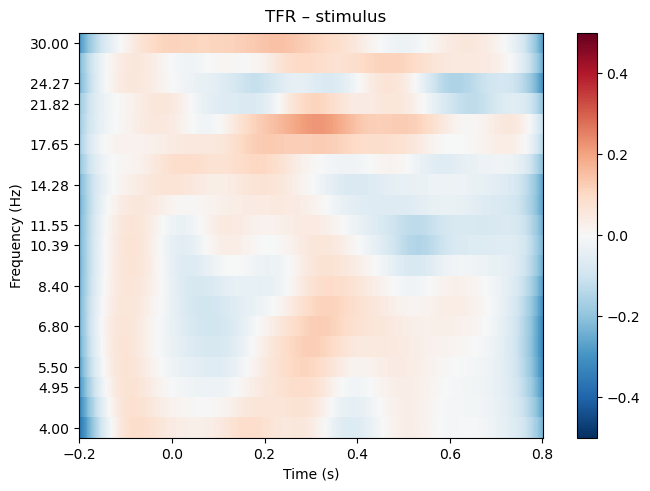

/var/folders/3j/w0qrc74d6sj7fjdwc593xcqc0000gn/T/ipykernel_17474/2132749444.py:9: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  power.plot(picks='eeg', title=f"TFR – {cond}", vmin=-0.5, vmax=0.5, cmap='RdBu_r')


<Figure size 640x480 with 0 Axes>

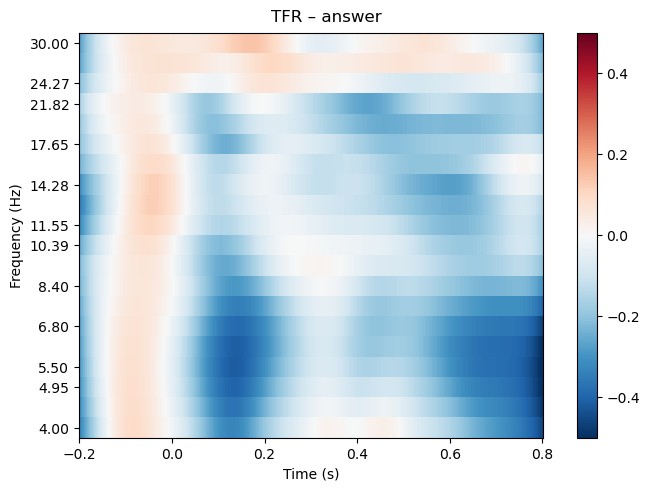

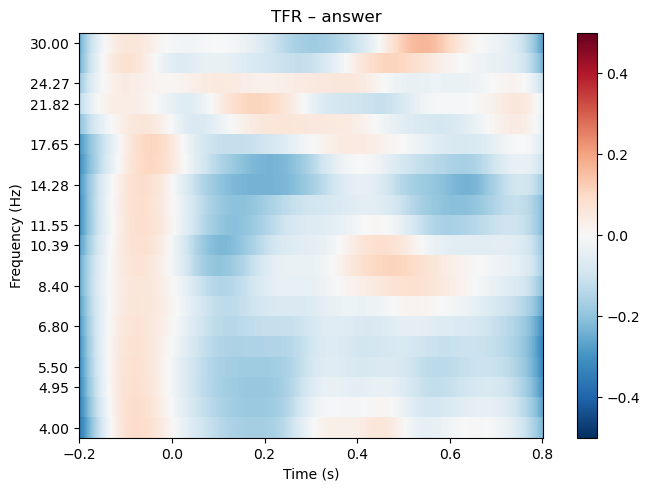

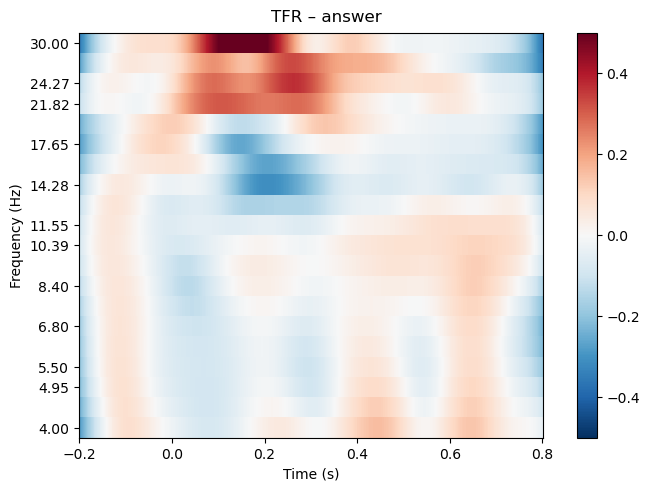

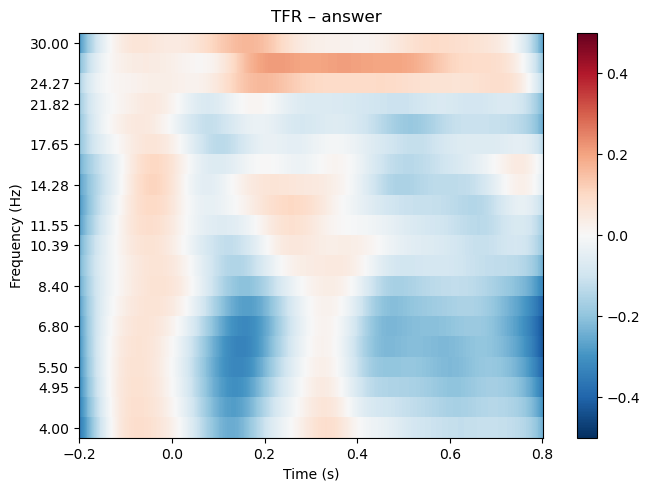

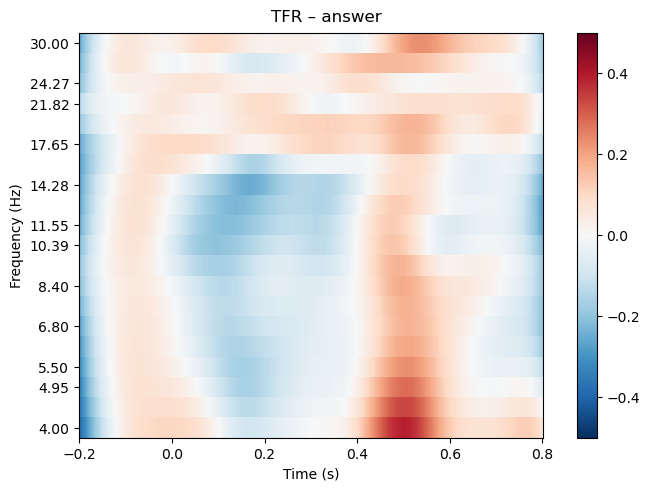

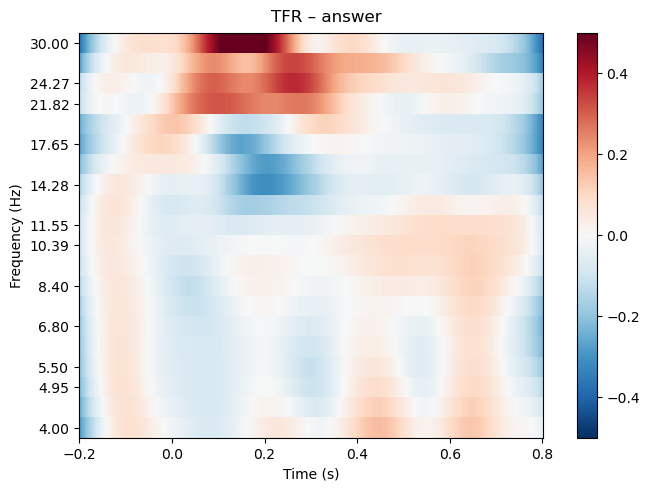

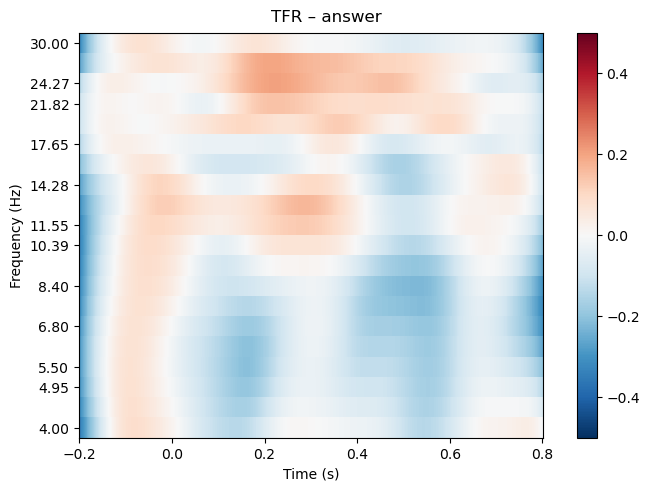

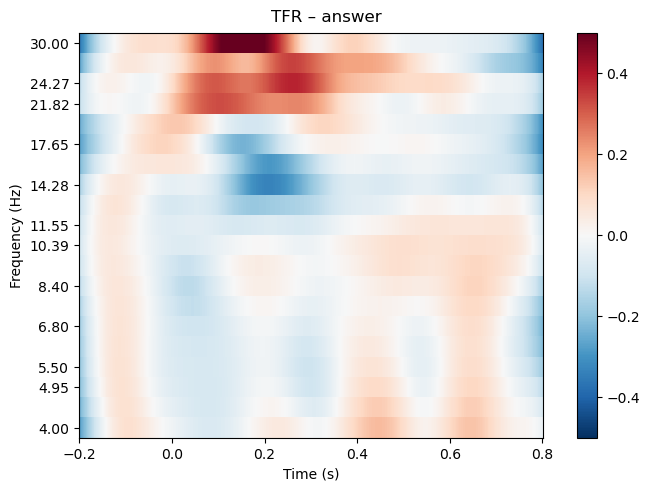

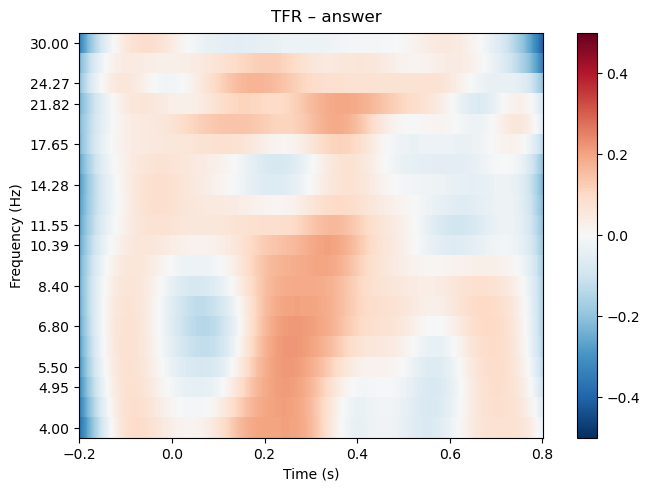

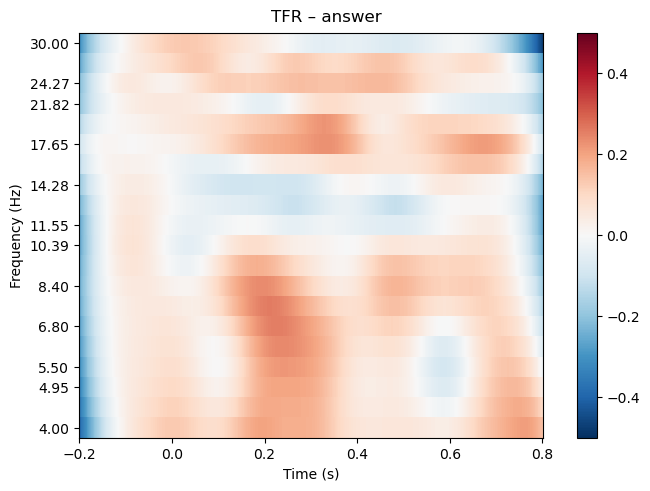

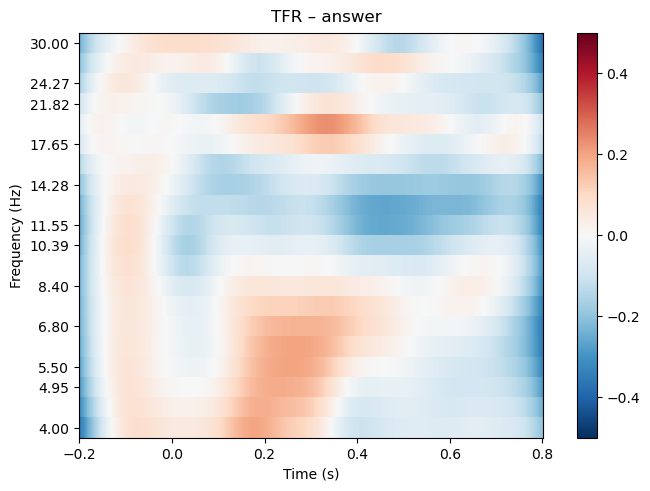

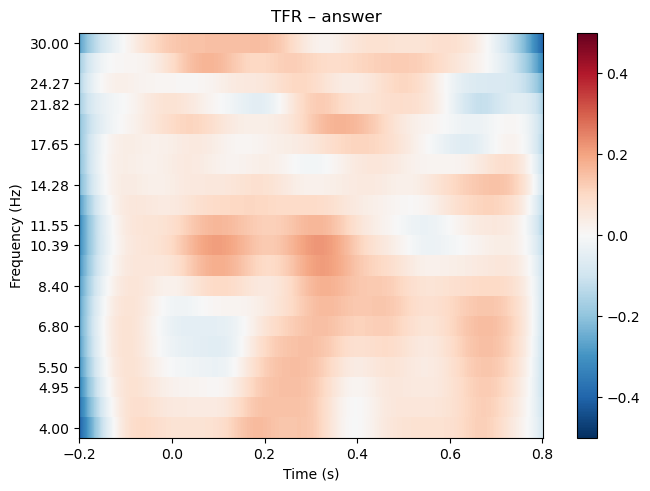

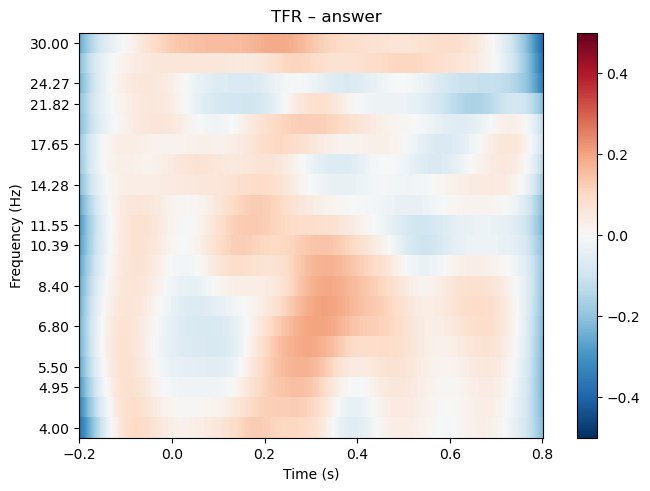

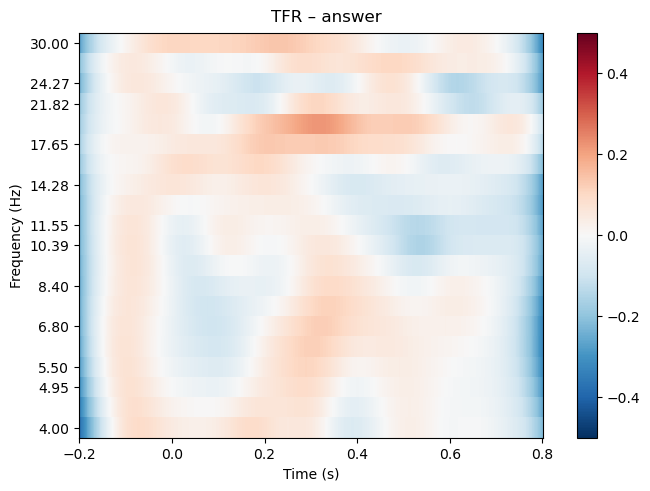

In [9]:

freqs = np.logspace(np.log10(4), np.log10(30), 20)
n_cycles = freqs / 2.

for cond in event_id:
    # power = mne.time_frequency.tfr_morlet(epochs[cond], freqs=freqs, n_cycles=n_cycles,
    #                                       use_fft=True, return_itc=False, decim=3, n_jobs='auto')
    power = epochs[cond].compute_tfr(freqs=freqs, tmin=tmin, tmax=tmax, n_cycles=n_cycles, method='morlet', return_itc=False, average=True)
    power.apply_baseline(baseline=(-0.2, 0), mode='logratio')
    power.plot(picks='eeg', title=f"TFR – {cond}", vmin=-0.5, vmax=0.5, cmap='RdBu_r')
    plt.savefig(FIG_DIR / f"tfr_{cond}.png", dpi=150)


### 5. Band‑Power Topographies

In [13]:
# --------------------------- Band-Power Topographies ---------------------------
import numpy as np
import matplotlib.pyplot as plt
import mne

bands = {"theta": (4, 7), "alpha": (8, 12), "beta": (13, 30)}

for cond in event_id:                      # 'stimulus', 'answer', …
    # Pull data as (n_epochs, n_channels, n_times)
    data = epochs[cond].get_data()
    sfreq = epochs.info["sfreq"]
    n_epochs, n_channels, n_times = data.shape

    # Largest power-of-two n_fft that does NOT exceed epoch length
    n_fft = 2 ** int(np.floor(np.log2(n_times)))      # e.g. 256-sample epoch → n_fft=256

    # Welch PSD for the full 1–40 Hz range (average over epochs already)
    psds, freqs = mne.time_frequency.psd_array_welch(
        data, sfreq=sfreq,
        fmin=1., fmax=40.,
        n_fft=n_fft, n_per_seg=n_fft,
        average="mean"         # → psds shape = (n_epochs, n_channels, n_freqs)
    )

    # Average across epochs first → (n_channels, n_freqs)
    psds_mean = psds.mean(axis=0)

    for band, (fmin, fmax) in bands.items():
        mask = (freqs >= fmin) & (freqs <= fmax)
        if not mask.any():
            raise RuntimeError(
                f"No frequency bins between {fmin}–{fmax} Hz "
                f"with n_fft={n_fft} and sfreq={sfreq}. "
                "Increase epoch length or sampling rate."
            )

        # Mean across the selected freqs → vector of length n_channels
        mean_psd = psds_mean[:, mask].mean(axis=1)

        # ---------- Topomap ----------
        fig, ax = plt.subplots()
        mne.viz.plot_topomap(
            mean_psd, epochs.info,
            axes=ax, show=False, cmap="Reds",
            contours=0,
            vlim=(mean_psd.min(), mean_psd.max()),
        )
        ax.set_title(f"{band.capitalize()} power – {cond}")
        fig.savefig(FIG_DIR / f"band_{band}_{cond}.png", dpi=150)
        plt.close(fig)

print("Band-power topomaps saved to", FIG_DIR.resolve())

Band-power topomaps saved to /Users/rahul/PycharmProjects/Thesis-EEG/Data Processing(Acquired)/Visualisations


In [14]:

for cond, evoked in evoked_dict.items():
    evoked.save(DERIV_DIR / f"evoked_{cond}.fif", overwrite=True)
print("Evoked data saved to", DERIV_DIR.resolve())


Evoked data saved to /Users/rahul/PycharmProjects/Thesis-EEG/Data Processing(Acquired)/derivatives


/var/folders/3j/w0qrc74d6sj7fjdwc593xcqc0000gn/T/ipykernel_17474/2475379221.py:2: RuntimeWarning: This filename (/Users/rahul/PycharmProjects/Thesis-EEG/Data Processing(Acquired)/derivatives/evoked_stimulus.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  evoked.save(DERIV_DIR / f"evoked_{cond}.fif", overwrite=True)
/var/folders/3j/w0qrc74d6sj7fjdwc593xcqc0000gn/T/ipykernel_17474/2475379221.py:2: RuntimeWarning: This filename (/Users/rahul/PycharmProjects/Thesis-EEG/Data Processing(Acquired)/derivatives/evoked_answer.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  evoked.save(DERIV_DIR / f"evoked_{cond}.fif", overwrite=True)


Notebook complete – all outputs saved to disk.